# Graph Strategy Ablation Study - Analysis

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import json
import glob
from datetime import datetime
import warnings
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind, f_oneway
import itertools
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Configuration and Data Loading

In [38]:
from dotenv import load_dotenv

# Configuration
load_dotenv()
RESULTS_BASE_DIR = os.path.join(os.getenv("OUT_DIR", "."), 'traffic_gnn_results', 'graph_ablation_*')

def find_latest_ablation_experiment():
    """Find the most recent ablation experiment directory"""
    experiment_dirs = glob.glob(RESULTS_BASE_DIR)
    
    if not experiment_dirs:
        print("No ablation experiment directories found!")
        print("Please run the training script first:")
        print("   python traffic_graph_ablation_training.py --runs 5 --graphs all")
        return None
    
    # Sort by modification time (newest first)
    experiment_dirs.sort(key=os.path.getmtime, reverse=True)
    latest_dir = experiment_dirs[0]
    
    print(f"Found latest ablation experiment: {os.path.basename(latest_dir)}")
    return latest_dir

def load_ablation_results(experiment_dir):
    """Load ablation results from experiment directory"""
    if not experiment_dir:
        return None, None, None
    
    # Load main results
    results_file = os.path.join(experiment_dir, 'ablation_results.json')
    if not os.path.exists(results_file):
        print(f"Results file not found: {results_file}")
        return None, None, None
    
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    # Load summary CSV
    summary_file = os.path.join(experiment_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_file) if os.path.exists(summary_file) else None
    
    # Load detailed results CSV
    detailed_file = os.path.join(experiment_dir, 'detailed_results.csv')
    detailed_df = pd.read_csv(detailed_file) if os.path.exists(detailed_file) else None
    
    print(f"Loaded ablation results:")
    print(f"   Experiment: {results['experiment_info']['timestamp']}")
    print(f"   Strategies: {results['experiment_info']['num_strategies']}")
    print(f"   Runs per strategy: {results['experiment_info']['num_runs']}")
    print(f"   Device: {results['experiment_info']['device']}")
    
    return results, summary_df, detailed_df

# Load experiment results
EXPERIMENT_DIR = find_latest_ablation_experiment()
results, summary_df, detailed_df = load_ablation_results(EXPERIMENT_DIR)

if results:
    print(f"\nData Summary:")
    if summary_df is not None:
        print(f"   Summary data: {summary_df.shape}")
        print(f"   Strategies: {list(summary_df['strategy'])}")
    if detailed_df is not None:
        print(f"   Detailed data: {detailed_df.shape}")
        print(f"   Total runs: {len(detailed_df)}")

Found latest ablation experiment: graph_ablation_20250730_105049
Loaded ablation results:
   Experiment: 2025-07-30T16:15:37.160290
   Strategies: 9
   Runs per strategy: 1
   Device: cuda

Data Summary:
   Summary data: (8, 10)
   Strategies: ['corr_0.9', 'corr_0.3', 'corr_0.5', 'knn_12', 'knn_10', 'knn_8', 'knn_5', 'corr_0.7']
   Detailed data: (8, 7)
   Total runs: 8


## 2. Statistical Analysis

In [39]:
def perform_statistical_analysis(detailed_df):
    """Perform comprehensive statistical analysis"""
    if detailed_df is None:
        print("No detailed data available for statistical analysis")
        return None
    
    print("Statistical Analysis:")
    print("=" * 40)
    
    # Basic statistics
    strategy_stats = detailed_df.groupby('strategy')['test_mae'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(4)
    
    print("\nStrategy Performance Statistics:")
    print(strategy_stats)
    
    # ANOVA test
    strategies = detailed_df['strategy'].unique()
    strategy_data = [detailed_df[detailed_df['strategy'] == s]['test_mae'].values for s in strategies]
    
    f_stat, p_value_anova = f_oneway(*strategy_data)
    print(f"\nANOVA Test:")
    print(f"   F-statistic: {f_stat:.4f}")
    print(f"   p-value: {p_value_anova:.6f}")
    print(f"   Significant difference: {'Yes' if p_value_anova < 0.05 else 'No'}")
    
    # Pairwise t-tests
    print(f"\nPairwise t-tests (Bonferroni corrected):")
    
    pairwise_results = []
    strategy_pairs = list(itertools.combinations(strategies, 2))
    alpha_corrected = 0.05 / len(strategy_pairs)  # Bonferroni correction
    
    for s1, s2 in strategy_pairs:
        data1 = detailed_df[detailed_df['strategy'] == s1]['test_mae'].values
        data2 = detailed_df[detailed_df['strategy'] == s2]['test_mae'].values
        
        t_stat, p_value = ttest_ind(data1, data2)
        
        significant = p_value < alpha_corrected
        better_strategy = s1 if np.mean(data1) < np.mean(data2) else s2
        
        pairwise_results.append({
            'strategy_1': s1,
            'strategy_2': s2,
            'mean_1': np.mean(data1),
            'mean_2': np.mean(data2),
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': significant,
            'better_strategy': better_strategy
        })
        
        sig_marker = "***" if significant else "ns"
        print(f"   {s1} vs {s2}: p={p_value:.4f} {sig_marker} (better: {better_strategy})")
    
    pairwise_df = pd.DataFrame(pairwise_results)
    
    print(f"\nSummary:")
    print(f"   Total comparisons: {len(strategy_pairs)}")
    print(f"   Significant differences: {sum(pairwise_df['significant'])}")
    print(f"   Corrected alpha level: {alpha_corrected:.4f}")
    
    return {
        'strategy_stats': strategy_stats,
        'anova': {'f_stat': f_stat, 'p_value': p_value_anova},
        'pairwise_tests': pairwise_df,
        'alpha_corrected': alpha_corrected
    }

# Perform statistical analysis
if detailed_df is not None:
    statistical_results = perform_statistical_analysis(detailed_df)
else:
    print("No detailed data available for statistical analysis")
    statistical_results = None

Statistical Analysis:

Strategy Performance Statistics:
          count    mean  std     min     max
strategy                                    
corr_0.3      1  0.2015  NaN  0.2015  0.2015
corr_0.5      1  0.2199  NaN  0.2199  0.2199
corr_0.7      1  0.2338  NaN  0.2338  0.2338
corr_0.9      1  0.1922  NaN  0.1922  0.1922
knn_10        1  0.2274  NaN  0.2274  0.2274
knn_12        1  0.2270  NaN  0.2270  0.2270
knn_5         1  0.2294  NaN  0.2294  0.2294
knn_8         1  0.2281  NaN  0.2281  0.2281

ANOVA Test:
   F-statistic: nan
   p-value: nan
   Significant difference: No

Pairwise t-tests (Bonferroni corrected):
   knn_5 vs knn_8: p=nan ns (better: knn_8)
   knn_5 vs knn_10: p=nan ns (better: knn_10)
   knn_5 vs knn_12: p=nan ns (better: knn_12)
   knn_5 vs corr_0.3: p=nan ns (better: corr_0.3)
   knn_5 vs corr_0.5: p=nan ns (better: corr_0.5)
   knn_5 vs corr_0.7: p=nan ns (better: knn_5)
   knn_5 vs corr_0.9: p=nan ns (better: corr_0.9)
   knn_8 vs knn_10: p=nan ns (better: kn

## 3. Performance Comparison Visualizations

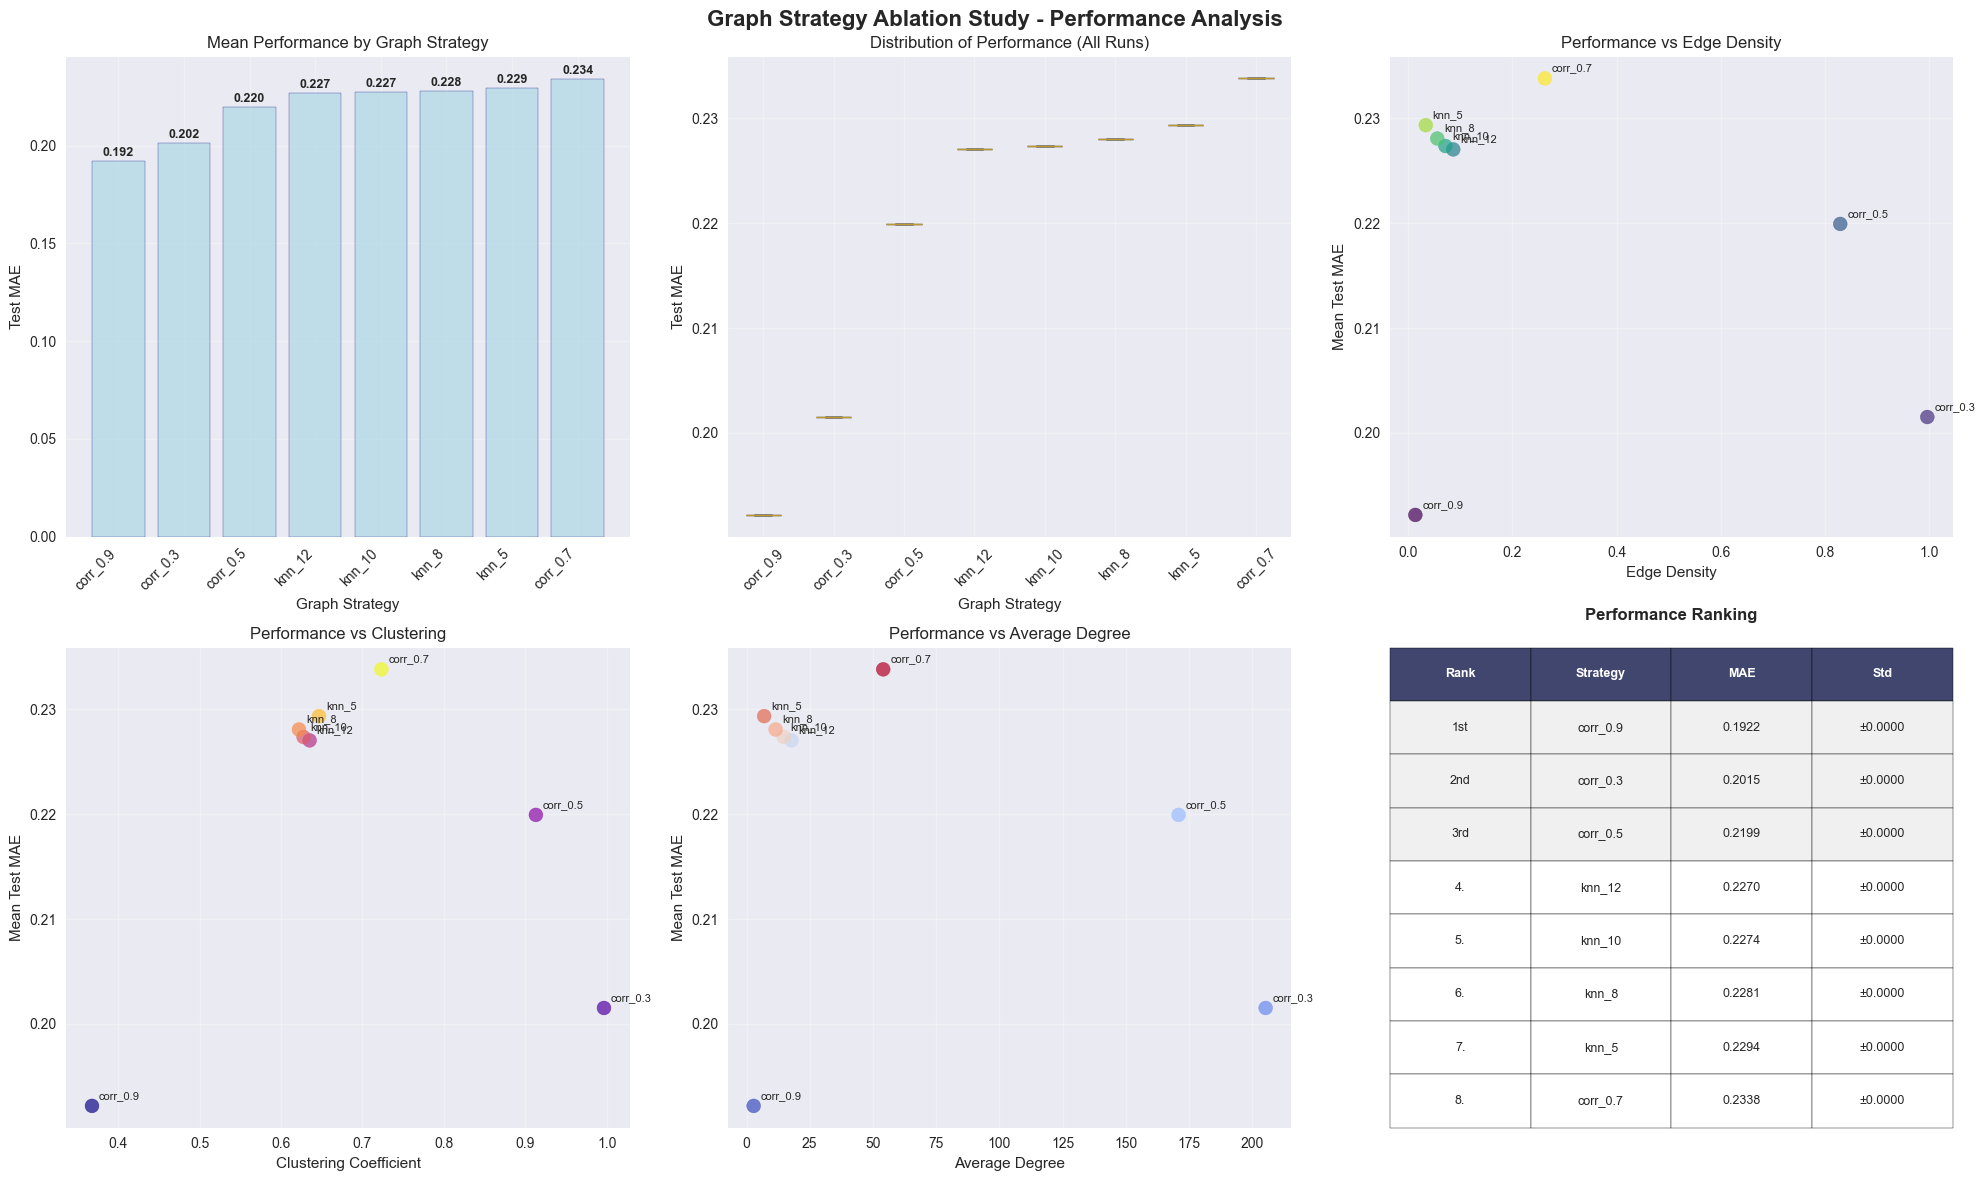

In [40]:
def create_performance_visualizations(summary_df, detailed_df):
    """Create comprehensive performance comparison visualizations"""
    if summary_df is None or detailed_df is None:
        print("No data available for visualization")
        return
    
    # Create comprehensive figure
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Graph Strategy Ablation Study - Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Mean performance with error bars
    summary_sorted = summary_df.sort_values('mean_test_mae')
    
    bars = axes[0,0].bar(range(len(summary_sorted)), summary_sorted['mean_test_mae'], 
                        yerr=summary_sorted['std_test_mae'], 
                        alpha=0.7, capsize=5, color='lightblue', edgecolor='navy')
    
    axes[0,0].set_xlabel('Graph Strategy')
    axes[0,0].set_ylabel('Test MAE')
    axes[0,0].set_title('Mean Performance by Graph Strategy')
    axes[0,0].set_xticks(range(len(summary_sorted)))
    axes[0,0].set_xticklabels(summary_sorted['strategy'], rotation=45, ha='right')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, mae, std) in enumerate(zip(bars, summary_sorted['mean_test_mae'], summary_sorted['std_test_mae'])):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.001, 
                      f'{mae:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2. Box plot of all runs
    strategy_order = summary_sorted['strategy'].tolist()
    detailed_ordered = detailed_df.set_index('strategy').loc[strategy_order].reset_index()
    
    bp = axes[0,1].boxplot([detailed_df[detailed_df['strategy'] == s]['test_mae'].values 
                           for s in strategy_order], 
                          labels=strategy_order, patch_artist=True)
    
    # Color boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(strategy_order)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0,1].set_xlabel('Graph Strategy')
    axes[0,1].set_ylabel('Test MAE')
    axes[0,1].set_title('Distribution of Performance (All Runs)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Scatter plot: Edge density vs Performance
    axes[0,2].scatter(summary_sorted['edge_density'], summary_sorted['mean_test_mae'], 
                     s=100, alpha=0.7, c=range(len(summary_sorted)), cmap='viridis')
    
    for i, row in summary_sorted.iterrows():
        axes[0,2].annotate(row['strategy'], 
                          (row['edge_density'], row['mean_test_mae']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[0,2].set_xlabel('Edge Density')
    axes[0,2].set_ylabel('Mean Test MAE')
    axes[0,2].set_title('Performance vs Edge Density')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Clustering coefficient vs Performance
    axes[1,0].scatter(summary_sorted['clustering_coefficient'], summary_sorted['mean_test_mae'], 
                     s=100, alpha=0.7, c=range(len(summary_sorted)), cmap='plasma')
    
    for i, row in summary_sorted.iterrows():
        axes[1,0].annotate(row['strategy'], 
                          (row['clustering_coefficient'], row['mean_test_mae']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[1,0].set_xlabel('Clustering Coefficient')
    axes[1,0].set_ylabel('Mean Test MAE')
    axes[1,0].set_title('Performance vs Clustering')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Average degree vs Performance
    axes[1,1].scatter(summary_sorted['avg_degree'], summary_sorted['mean_test_mae'], 
                     s=100, alpha=0.7, c=range(len(summary_sorted)), cmap='coolwarm')
    
    for i, row in summary_sorted.iterrows():
        axes[1,1].annotate(row['strategy'], 
                          (row['avg_degree'], row['mean_test_mae']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[1,1].set_xlabel('Average Degree')
    axes[1,1].set_ylabel('Mean Test MAE')
    axes[1,1].set_title('Performance vs Average Degree')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Performance ranking table
    axes[1,2].axis('off')
    
    # Create ranking table
    ranking_data = []
    for i, (_, row) in enumerate(summary_sorted.iterrows(), 1):
        medal = "1st" if i == 1 else "2nd" if i == 2 else "3rd" if i == 3 else f"{i}."
        ranking_data.append([
            medal,
            row['strategy'][:12] + '...' if len(row['strategy']) > 15 else row['strategy'],
            f"{row['mean_test_mae']:.4f}",
            f"±{row['std_test_mae']:.4f}"
        ])
    
    table = axes[1,2].table(cellText=ranking_data, 
                           colLabels=['Rank', 'Strategy', 'MAE', 'Std'],
                           cellLoc='center', loc='center',
                           bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    # Style the table
    for i in range(len(ranking_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#40466e')
                cell.set_text_props(weight='bold', color='white')
            else:
                if i <= 3:  # Top 3
                    cell.set_facecolor('#f0f0f0')
                cell.set_text_props(fontsize=9)
    
    axes[1,2].set_title('Performance Ranking', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create performance visualizations
if summary_df is not None and detailed_df is not None:
    performance_fig = create_performance_visualizations(summary_df, detailed_df)
else:
    print("No data available for performance visualization")

## 4. Interactive Dashboard

In [41]:
def create_interactive_dashboard(summary_df, detailed_df):
    """Create interactive dashboard with plotly"""
    if summary_df is None or detailed_df is None:
        print("⚠️  No data available for interactive dashboard")
        return
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('Performance Ranking', 'Performance Distribution', 
                       'Graph Properties vs Performance', 'Edge Density Analysis',
                       'Strategy Comparison Matrix', 'Statistical Significance'),
        specs=[[{"type": "bar"}, {"type": "box"}, {"type": "scatter"}],
               [{"type": "scatter"}, {"type": "scatter"}, {"type": "table"}]]
    )
    
    # Sort data
    summary_sorted = summary_df.sort_values('mean_test_mae')
    
    # 1. Performance ranking bar chart
    fig.add_trace(
        go.Bar(
            x=summary_sorted['strategy'],
            y=summary_sorted['mean_test_mae'],
            error_y=dict(type='data', array=summary_sorted['std_test_mae']),
            name='Mean MAE',
            text=[f'{mae:.4f}±{std:.4f}' for mae, std in 
                  zip(summary_sorted['mean_test_mae'], summary_sorted['std_test_mae'])],
            textposition='outside',
            marker_color='lightblue'
        ),
        row=1, col=1
    )
    
    # 2. Box plot of all runs
    for strategy in summary_sorted['strategy']:
        strategy_data = detailed_df[detailed_df['strategy'] == strategy]['test_mae']
        fig.add_trace(
            go.Box(
                y=strategy_data,
                name=strategy,
                showlegend=False
            ),
            row=1, col=2
        )
    
    # 3. Graph properties scatter
    fig.add_trace(
        go.Scatter(
            x=summary_sorted['edge_density'],
            y=summary_sorted['mean_test_mae'],
            mode='markers+text',
            text=summary_sorted['strategy'],
            textposition='top center',
            marker=dict(size=10, color=summary_sorted['clustering_coefficient'], 
                       colorscale='viridis', showscale=True,
                       colorbar=dict(title='Clustering Coefficient')),
            name='Strategies',
            showlegend=False
        ),
        row=1, col=3
    )
    
    # 4. Edge density analysis
    fig.add_trace(
        go.Scatter(
            x=summary_sorted['num_edges'],
            y=summary_sorted['mean_test_mae'],
            mode='markers+text',
            text=summary_sorted['strategy'],
            textposition='top center',
            marker=dict(size=summary_sorted['avg_degree'], 
                       color='lightcoral', opacity=0.7,
                       sizemode='diameter', sizeref=2.*max(summary_sorted['avg_degree'])/(40.**2)),
            name='Edge Analysis',
            showlegend=False
        ),
        row=2, col=1
    )
    
    # 5. Strategy comparison matrix
    fig.add_trace(
        go.Scatter(
            x=summary_sorted['avg_degree'],
            y=summary_sorted['clustering_coefficient'],
            mode='markers+text',
            text=summary_sorted['strategy'],
            textposition='middle right',
            marker=dict(size=15, color=summary_sorted['mean_test_mae'], 
                       colorscale='RdYlBu_r', showscale=True,
                       colorbar=dict(title='Mean Test MAE', x=0.85)),
            name='Comparison Matrix',
            showlegend=False
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text="Graph Strategy Ablation Study - Interactive Analysis Dashboard",
        title_x=0.5
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Strategy", row=1, col=1)
    fig.update_yaxes(title_text="Test MAE", row=1, col=1)
    
    fig.update_xaxes(title_text="Strategy", row=1, col=2)
    fig.update_yaxes(title_text="Test MAE", row=1, col=2)
    
    fig.update_xaxes(title_text="Edge Density", row=1, col=3)
    fig.update_yaxes(title_text="Mean Test MAE", row=1, col=3)
    
    fig.update_xaxes(title_text="Number of Edges", row=2, col=1)
    fig.update_yaxes(title_text="Mean Test MAE", row=2, col=1)
    
    fig.update_xaxes(title_text="Average Degree", row=2, col=2)
    fig.update_yaxes(title_text="Clustering Coefficient", row=2, col=2)
    
    fig.show()
    
    return fig

# Create interactive dashboard
if summary_df is not None and detailed_df is not None:
    interactive_fig = create_interactive_dashboard(summary_df, detailed_df)
else:
    print("⚠️  No data available for interactive dashboard")

## 5. Graph Property Correlation Analysis

📊 Graph Property Correlation Analysis:

🔗 Correlation Matrix:
                        mean_test_mae  mean_test_loss  num_edges  avg_degree  \
mean_test_mae                  1.0000          0.9549    -0.3197     -0.3197   
mean_test_loss                 0.9549          1.0000    -0.5268     -0.5268   
num_edges                     -0.3197         -0.5268     1.0000      1.0000   
avg_degree                    -0.3197         -0.5268     1.0000      1.0000   
edge_density                  -0.3197         -0.5268     1.0000      1.0000   
clustering_coefficient         0.0960         -0.1433     0.8976      0.8976   

                        edge_density  clustering_coefficient  
mean_test_mae                -0.3197                  0.0960  
mean_test_loss               -0.5268                 -0.1433  
num_edges                     1.0000                  0.8976  
avg_degree                    1.0000                  0.8976  
edge_density                  1.0000                  0.8976  

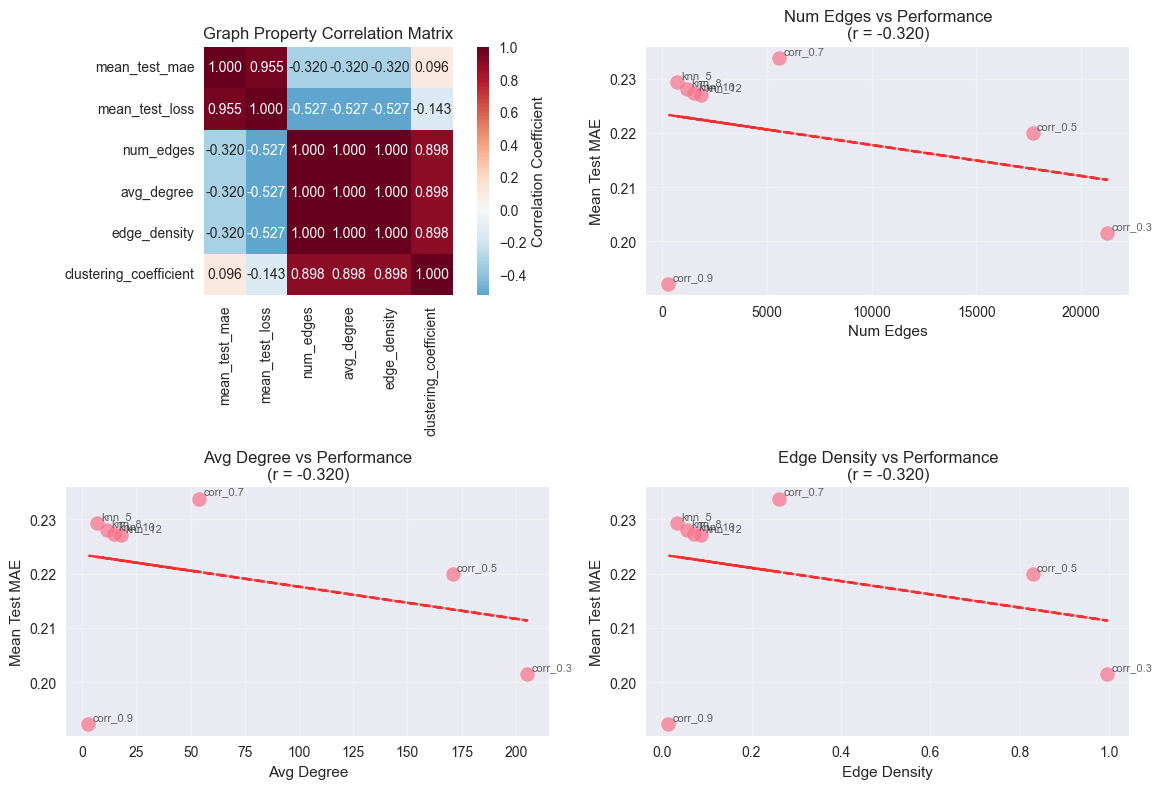


🔍 Strongest Correlations with Performance:
   mean_test_loss: 0.955 (strong positive)
   num_edges: 0.320 (weak negative)
   avg_degree: 0.320 (weak negative)
   edge_density: 0.320 (weak negative)
   clustering_coefficient: 0.096 (weak positive)


In [42]:
def analyze_graph_property_correlations(summary_df):
    """Analyze correlations between graph properties and performance"""
    if summary_df is None:
        print("⚠️  No summary data available for correlation analysis")
        return None
    
    print("📊 Graph Property Correlation Analysis:")
    print("=" * 45)
    
    # Select relevant columns for correlation analysis
    correlation_cols = ['mean_test_mae', 'mean_test_loss', 'num_edges', 'avg_degree', 
                       'edge_density', 'clustering_coefficient']
    
    # Filter available columns
    available_cols = [col for col in correlation_cols if col in summary_df.columns]
    
    if len(available_cols) < 3:
        print("⚠️  Insufficient columns for correlation analysis")
        return None
    
    # Calculate correlation matrix
    corr_data = summary_df[available_cols]
    correlation_matrix = corr_data.corr()
    
    print(f"\n🔗 Correlation Matrix:")
    print(correlation_matrix.round(4))
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    
    # Correlation heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Graph Property Correlation Matrix')
    
    # Performance vs properties scatter plots
    property_cols = [col for col in available_cols if col not in ['mean_test_mae', 'mean_test_loss']]
    
    for i, prop in enumerate(property_cols[:3]):
        plt.subplot(2, 2, i + 2)
        plt.scatter(summary_df[prop], summary_df['mean_test_mae'], alpha=0.7, s=100)
        
        # Add trend line
        z = np.polyfit(summary_df[prop], summary_df['mean_test_mae'], 1)
        p = np.poly1d(z)
        plt.plot(summary_df[prop], p(summary_df[prop]), "r--", alpha=0.8)
        
        # Calculate correlation coefficient
        corr_coef = correlation_matrix.loc['mean_test_mae', prop]
        
        plt.xlabel(prop.replace('_', ' ').title())
        plt.ylabel('Mean Test MAE')
        plt.title(f'{prop.replace("_", " ").title()} vs Performance\n(r = {corr_coef:.3f})')
        plt.grid(True, alpha=0.3)
        
        # Annotate points
        for _, row in summary_df.iterrows():
            plt.annotate(row['strategy'][:8], (row[prop], row['mean_test_mae']),
                        xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Identify strongest correlations with performance
    performance_correlations = correlation_matrix['mean_test_mae'].abs().sort_values(ascending=False)
    
    print(f"\n🔍 Strongest Correlations with Performance:")
    for prop, corr in performance_correlations.items():
        if prop != 'mean_test_mae':
            direction = "positive" if correlation_matrix.loc['mean_test_mae', prop] > 0 else "negative"
            strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.4 else "weak"
            print(f"   {prop}: {corr:.3f} ({strength} {direction})")
    
    return correlation_matrix

# Analyze correlations
if summary_df is not None:
    correlation_results = analyze_graph_property_correlations(summary_df)
else:
    print("⚠️  No data available for correlation analysis")
    correlation_results = None

## 6. LaTeX Export Functions

In [43]:
def export_latex_tables(summary_df, statistical_results, experiment_dir):
    """Export LaTeX-ready tables for paper integration"""
    if summary_df is None:
        print("⚠️  No data available for LaTeX export")
        return
    
    print("📝 Exporting LaTeX Tables:")
    print("=" * 30)
    
    # 1. Performance results table
    performance_table = create_performance_latex_table(summary_df)
    
    # 2. Statistical significance table
    if statistical_results and 'pairwise_tests' in statistical_results:
        significance_table = create_significance_latex_table(statistical_results['pairwise_tests'])
    else:
        significance_table = "% Statistical significance table not available\n"
    
    # 3. Graph properties table
    properties_table = create_properties_latex_table(summary_df)
    
    # Save to files
    if experiment_dir:
        latex_dir = os.path.join(experiment_dir, 'latex_tables')
        os.makedirs(latex_dir, exist_ok=True)
        
        # Save individual tables
        with open(os.path.join(latex_dir, 'performance_table.tex'), 'w') as f:
            f.write(performance_table)
        
        with open(os.path.join(latex_dir, 'significance_table.tex'), 'w') as f:
            f.write(significance_table)
        
        with open(os.path.join(latex_dir, 'properties_table.tex'), 'w') as f:
            f.write(properties_table)
        
        # Combined file
        combined_latex = f"""
% Graph Strategy Ablation Study - LaTeX Tables
% Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

% Performance Results Table
{performance_table}

% Statistical Significance Table
{significance_table}

% Graph Properties Table
{properties_table}
"""
        
        with open(os.path.join(latex_dir, 'all_tables.tex'), 'w') as f:
            f.write(combined_latex)
        
        print(f"✅ LaTeX tables saved to: {latex_dir}")
    
    # Display tables
    print("\n📊 Performance Results Table:")
    print(performance_table)
    
    print("\n📊 Graph Properties Table:")
    print(properties_table)
    
    return {
        'performance_table': performance_table,
        'significance_table': significance_table,
        'properties_table': properties_table
    }

def create_performance_latex_table(summary_df):
    """Create LaTeX table for performance results"""
    summary_sorted = summary_df.sort_values('mean_test_mae')
    
    latex = """
\\begin{table}[!t]
\\centering
\\caption{Graph Strategy Performance Comparison}
\\label{tab:graph_strategy_performance}
\\begin{tabular}{l|c|c|c|c}
\\toprule
\\textbf{Graph Strategy} & \\textbf{Test MAE} & \\textbf{Test Loss} & \\textbf{Edges} & \\textbf{Density} \\\\
\\midrule
"""
    
    for i, (_, row) in enumerate(summary_sorted.iterrows()):
        strategy = row['strategy'].replace('_', '\\_')
        mae = f"{row['mean_test_mae']:.4f} $\\pm$ {row['std_test_mae']:.4f}"
        loss = f"{row['mean_test_loss']:.4f} $\\pm$ {row['std_test_loss']:.4f}"
        edges = f"{int(row['num_edges'])}"
        density = f"{row['edge_density']:.3f}"
        
        # Bold the best result
        if i == 0:
            mae = f"\\textbf{{{mae}}}"
        
        latex += f"{strategy} & {mae} & {loss} & {edges} & {density} \\\\\n"
    
    latex += """
\\bottomrule
\\end{tabular}
\\end{table}
"""
    
    return latex

def create_significance_latex_table(pairwise_df):
    """Create LaTeX table for statistical significance results"""
    significant_pairs = pairwise_df[pairwise_df['significant']]
    
    if len(significant_pairs) == 0:
        return "% No statistically significant differences found\n"
    
    latex = """
\\begin{table}[!t]
\\centering
\\caption{Statistically Significant Pairwise Comparisons}
\\label{tab:statistical_significance}
\\begin{tabular}{l|l|c|c}
\\toprule
\\textbf{Strategy 1} & \\textbf{Strategy 2} & \\textbf{p-value} & \\textbf{Better Strategy} \\\\
\\midrule
"""
    
    for _, row in significant_pairs.iterrows():
        s1 = row['strategy_1'].replace('_', '\\_')
        s2 = row['strategy_2'].replace('_', '\\_')
        p_val = f"{row['p_value']:.4f}"
        better = row['better_strategy'].replace('_', '\\_')
        
        latex += f"{s1} & {s2} & {p_val} & \\textbf{{{better}}} \\\\\n"
    
    latex += """
\\bottomrule
\\end{tabular}
\\end{table}
"""
    
    return latex

def create_properties_latex_table(summary_df):
    """Create LaTeX table for graph properties"""
    summary_sorted = summary_df.sort_values('mean_test_mae')
    
    latex = """
\\begin{table}[!t]
\\centering
\\caption{Graph Strategy Properties Analysis}
\\label{tab:graph_properties}
\\begin{tabular}{l|c|c|c|c}
\\toprule
\\textbf{Strategy} & \\textbf{Avg Degree} & \\textbf{Clustering} & \\textbf{Connected} & \\textbf{Performance Rank} \\\\
\\midrule
"""
    
    for i, (_, row) in enumerate(summary_sorted.iterrows(), 1):
        strategy = row['strategy'].replace('_', '\\_')
        avg_degree = f"{row['avg_degree']:.1f}"
        clustering = f"{row['clustering_coefficient']:.3f}"
        connected = "Yes" if row['is_connected'] else "No"
        rank = f"{i}"
        
        # Highlight best performer
        if i == 1:
            rank = f"\\textbf{{{rank}}}"
        
        latex += f"{strategy} & {avg_degree} & {clustering} & {connected} & {rank} \\\\\n"
    
    latex += """
\\bottomrule
\\end{tabular}
\\end{table}
"""
    
    return latex

# Export LaTeX tables
if summary_df is not None:
    latex_tables = export_latex_tables(summary_df, statistical_results, EXPERIMENT_DIR)
else:
    print("⚠️  No data available for LaTeX export")
    latex_tables = None

📝 Exporting LaTeX Tables:
✅ LaTeX tables saved to: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/graph_ablation_20250730_105049/latex_tables

📊 Performance Results Table:

\begin{table}[!t]
\centering
\caption{Graph Strategy Performance Comparison}
\label{tab:graph_strategy_performance}
\begin{tabular}{l|c|c|c|c}
\toprule
\textbf{Graph Strategy} & \textbf{Test MAE} & \textbf{Test Loss} & \textbf{Edges} & \textbf{Density} \\
\midrule
corr\_0.9 & \textbf{0.1922 $\pm$ 0.0000} & 0.1716 $\pm$ 0.0000 & 293 & 0.014 \\
corr\_0.3 & 0.2015 $\pm$ 0.0000 & 0.1710 $\pm$ 0.0000 & 21242 & 0.996 \\
corr\_0.5 & 0.2199 $\pm$ 0.0000 & 0.1763 $\pm$ 0.0000 & 17679 & 0.829 \\
knn\_12 & 0.2270 $\pm$ 0.0000 & 0.1803 $\pm$ 0.0000 & 1844 & 0.086 \\
knn\_10 & 0.2274 $\pm$ 0.0000 & 0.1806 $\pm$ 0.0000 & 1525 & 0.072 \\
knn\_8 & 0.2281 $\pm$ 0.0000 & 0.1812 $\pm$ 0.0000 & 1191 & 0.056 \\
knn\_5 & 0.2294 $\pm$ 0.0000 & 0.1824 $\pm$ 0.0000 & 721 & 0.034 \\
corr\_0.7 & 0.2338 $\pm$ 0.0000 & 0.1846 $\pm$ 0.000

## 7. Summary and Recommendations

In [44]:
def create_comprehensive_summary(results, summary_df, statistical_results):
    """Create comprehensive summary and recommendations"""
    if not results or summary_df is None:
        print("No data available for comprehensive summary")
        return
    
    print("COMPREHENSIVE ABLATION STUDY SUMMARY")
    print("=" * 60)
    
    # Experiment overview
    exp_info = results['experiment_info']
    data_info = results['data_info']
    
    print(f"Experiment Details:")
    print(f"   Timestamp: {exp_info['timestamp'][:19]}")
    print(f"   Device: {exp_info['device']}")
    print(f"   Strategies tested: {exp_info['num_strategies']}")
    print(f"   Runs per strategy: {exp_info['num_runs']}")
    print(f"   Total training runs: {exp_info['num_strategies'] * exp_info['num_runs']}")
    
    print(f"\nDataset Information:")
    print(f"   Sensors: {data_info['num_sensors']}")
    print(f"   Timesteps: {data_info['num_timesteps']}")
    print(f"   Training samples: {data_info['train_samples']}")
    print(f"   Test samples: {data_info['test_samples']}")
    
    # Performance ranking
    summary_sorted = summary_df.sort_values('mean_test_mae')
    
    print(f"\nPERFORMANCE RANKING:")
    print("-" * 50)
    
    for i, (_, row) in enumerate(summary_sorted.iterrows(), 1):
        medal = "1st" if i == 1 else "2nd" if i == 2 else "3rd" if i == 3 else f"{i}."
        mae = row['mean_test_mae']
        std = row['std_test_mae']
        print(f"{medal} {row['strategy']:15s} - MAE: {mae:.4f}±{std:.4f}")
    
    # Best strategy analysis
    best_strategy = summary_sorted.iloc[0]
    worst_strategy = summary_sorted.iloc[-1]
    
    improvement = ((worst_strategy['mean_test_mae'] - best_strategy['mean_test_mae']) / 
                   worst_strategy['mean_test_mae']) * 100
    
    print(f"\nKEY FINDINGS:")
    print(f"   Best strategy: {best_strategy['strategy']}")
    print(f"   Best performance: {best_strategy['mean_test_mae']:.4f}±{best_strategy['std_test_mae']:.4f}")
    print(f"   Worst strategy: {worst_strategy['strategy']}")
    print(f"   Performance improvement: {improvement:.1f}% (best vs worst)")
    
    # Graph property insights
    print(f"\nGRAPH PROPERTY INSIGHTS:")
    print(f"   Best strategy properties:")
    print(f"      Edges: {int(best_strategy['num_edges'])}")
    print(f"      Edge density: {best_strategy['edge_density']:.4f}")
    print(f"      Average degree: {best_strategy['avg_degree']:.2f}")
    print(f"      Clustering coefficient: {best_strategy['clustering_coefficient']:.4f}")
    print(f"      Connected: {'Yes' if best_strategy['is_connected'] else 'No'}")
    
    # Statistical significance
    if statistical_results:
        anova_result = statistical_results['anova']
        significant_pairs = statistical_results['pairwise_tests']['significant'].sum()
        total_pairs = len(statistical_results['pairwise_tests'])
        
        print(f"\nSTATISTICAL ANALYSIS:")
        print(f"   ANOVA p-value: {anova_result['p_value']:.6f}")
        print(f"   Overall significance: {'Yes' if anova_result['p_value'] < 0.05 else 'No'}")
        print(f"   Significant pairwise differences: {significant_pairs}/{total_pairs}")
    
    # Recommendations
    print(f"\nRECOMMENDATIONS FOR PAPER:")
    print("-" * 40)
    
    print(f"1. Best Graph Strategy:")
    print(f"   Use {best_strategy['strategy']} for optimal performance")
    print(f"   Achieves {best_strategy['mean_test_mae']:.4f} MAE with GraphTransformer")
    
    # Analyze strategy types
    knn_strategies = summary_sorted[summary_sorted['strategy'].str.contains('knn')]
    corr_strategies = summary_sorted[summary_sorted['strategy'].str.contains('corr')]
    
    if len(knn_strategies) > 1:
        best_knn = knn_strategies.iloc[0]
        print(f"2. k-NN Analysis:")
        print(f"   Best k-NN: {best_knn['strategy']} (MAE: {best_knn['mean_test_mae']:.4f})")
    
    if len(corr_strategies) > 1:
        best_corr = corr_strategies.iloc[0]
        print(f"3. Correlation Analysis:")
        print(f"   Best correlation: {best_corr['strategy']} (MAE: {best_corr['mean_test_mae']:.4f})")
    
    print(f"4. Performance Range:")
    print(f"   MAE range: {summary_sorted.iloc[0]['mean_test_mae']:.4f} - {summary_sorted.iloc[-1]['mean_test_mae']:.4f}")
    print(f"   Standard deviation range: {summary_sorted['std_test_mae'].min():.4f} - {summary_sorted['std_test_mae'].max():.4f}")

    return {
        'best_strategy': best_strategy['strategy'],
        'best_performance': best_strategy['mean_test_mae'],
        'improvement': improvement,
        'significant_differences': significant_pairs if statistical_results else 0
    }

# Create comprehensive summary
if results and summary_df is not None:
    summary_insights = create_comprehensive_summary(results, summary_df, statistical_results)
else:
    print("No data available for comprehensive summary")
    summary_insights = None

COMPREHENSIVE ABLATION STUDY SUMMARY
Experiment Details:
   Timestamp: 2025-07-30T16:15:37
   Device: cuda
   Strategies tested: 9
   Runs per strategy: 1
   Total training runs: 9

Dataset Information:
   Sensors: 207
   Timesteps: 34272
   Training samples: 23980
   Test samples: 3426

PERFORMANCE RANKING:
--------------------------------------------------
1st corr_0.9        - MAE: 0.1922±0.0000
2nd corr_0.3        - MAE: 0.2015±0.0000
3rd corr_0.5        - MAE: 0.2199±0.0000
4. knn_12          - MAE: 0.2270±0.0000
5. knn_10          - MAE: 0.2274±0.0000
6. knn_8           - MAE: 0.2281±0.0000
7. knn_5           - MAE: 0.2294±0.0000
8. corr_0.7        - MAE: 0.2338±0.0000

KEY FINDINGS:
   Best strategy: corr_0.9
   Best performance: 0.1922±0.0000
   Worst strategy: corr_0.7
   Performance improvement: 17.8% (best vs worst)

GRAPH PROPERTY INSIGHTS:
   Best strategy properties:
      Edges: 293
      Edge density: 0.0137
      Average degree: 2.83
      Clustering coefficient: 0.367

## 8. Export Results for Paper Integration

In [45]:
def save_analysis_results(experiment_dir):
    """Save analysis results for future reference"""
    if not experiment_dir:
        print("No experiment directory available for saving")
        return
    
    analysis_dir = os.path.join(experiment_dir, 'analysis_results')
    os.makedirs(analysis_dir, exist_ok=True)
    
    # Save analysis metadata
    analysis_meta = {
        'analysis_timestamp': datetime.now().isoformat(),
        'notebook_version': '1.0',
        'analysis_completed': True,
        'components_generated': [
            'statistical_analysis',
            'performance_visualizations', 
            'interactive_dashboard',
            'correlation_analysis',
            'latex_tables'
        ]
    }
    
    if summary_insights:
        analysis_meta['key_findings'] = summary_insights
    
    with open(os.path.join(analysis_dir, 'analysis_metadata.json'), 'w') as f:
        json.dump(analysis_meta, f, indent=2, default=str)
    
    # Save correlation results if available
    if correlation_results is not None:
        correlation_results.to_csv(os.path.join(analysis_dir, 'correlation_matrix.csv'))
    
    # Save statistical results if available
    if statistical_results:
        with open(os.path.join(analysis_dir, 'statistical_results.json'), 'w') as f:
            json.dump({
                'anova': statistical_results['anova'],
                'alpha_corrected': statistical_results['alpha_corrected']
            }, f, indent=2)
        
        statistical_results['pairwise_tests'].to_csv(
            os.path.join(analysis_dir, 'pairwise_tests.csv'), index=False
        )
    
    print(f"Analysis results saved to: {analysis_dir}")
    
    # Create README for the analysis
    readme_content = f"""
# Graph Strategy Ablation Study - Analysis Results

This directory contains the complete analysis results from the graph strategy ablation study.

## Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Contents:

### Data Files:
- `analysis_metadata.json` - Analysis configuration and key findings
- `correlation_matrix.csv` - Graph property correlation analysis
- `statistical_results.json` - ANOVA and significance test results
- `pairwise_tests.csv` - Detailed pairwise comparison results

### LaTeX Integration:
- `../latex_tables/` - Ready-to-use LaTeX tables for paper integration
- `performance_table.tex` - Performance comparison table
- `significance_table.tex` - Statistical significance results
- `properties_table.tex` - Graph properties analysis

### Key Findings:
"""
    
    if summary_insights:
        readme_content += f"""
- **Best Strategy**: {summary_insights['best_strategy']}
- **Best Performance**: {summary_insights['best_performance']:.4f} MAE
- **Performance Improvement**: {summary_insights['improvement']:.1f}% (best vs worst)
- **Significant Differences**: {summary_insights['significant_differences']} pairwise comparisons
"""
    
    readme_content += f"""

## Usage:

1. **For Paper Integration**:
   - Copy LaTeX tables from `latex_tables/` directory
   - Use correlation analysis for discussion
   - Reference statistical significance results

2. **For Further Analysis**:
   - Load `correlation_matrix.csv` for custom visualizations
   - Use `pairwise_tests.csv` for detailed comparisons
   - Refer to `analysis_metadata.json` for experiment context

## Files Generated by Analysis Notebook:
- Performance comparison visualizations
- Interactive dashboard with plotly
- Statistical analysis results
- Graph property correlation analysis
- LaTeX-ready tables for paper integration
"""
    
    with open(os.path.join(analysis_dir, 'README.md'), 'w') as f:
        f.write(readme_content)
    
    return analysis_dir

# Save analysis results
if EXPERIMENT_DIR:
    analysis_results_dir = save_analysis_results(EXPERIMENT_DIR)
    print(f"\nComplete analysis results available at: {analysis_results_dir}")
else:
    print("No experiment directory available for saving analysis results")

print("\n" + "="*60)
print("GRAPH STRATEGY ABLATION ANALYSIS COMPLETE!")
print("="*60)

if results:
    
    if summary_insights:
        print(f"\nKey finding: {summary_insights['best_strategy']} is the optimal graph strategy")
        print(f"   Achieves {summary_insights['best_performance']:.4f} MAE")
        print(f"   {summary_insights['improvement']:.1f}% improvement over worst strategy")

else:
    print(f"\nNo results to analyze. Please run the training script first:")
    print(f"      python traffic_graph_ablation_training.py --runs 5 --graphs all")

Analysis results saved to: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/graph_ablation_20250730_105049/analysis_results

Complete analysis results available at: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/graph_ablation_20250730_105049/analysis_results

GRAPH STRATEGY ABLATION ANALYSIS COMPLETE!

Key finding: corr_0.9 is the optimal graph strategy
   Achieves 0.1922 MAE
   17.8% improvement over worst strategy
